In [519]:
import pandas as pd
from pathlib import Path
import os
import warnings
warnings.filterwarnings("ignore")

PROJECT_ROOT = Path("..")
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "heart_disease_cleaned.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [520]:
X = df.drop("target", axis=1)
y = df["target"]

In [521]:
categorical_features = [
    "sex", "cp", "fbs", "restecg",
    "exang", "slope", "thal"
]

numerical_features = [
    "age", "trestbps", "chol",
    "thalach", "oldpeak", "ca"
]
print("Feature separation completed.")

Feature separation completed.


In [522]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [523]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Data split into training and testing sets.")

Data split into training and testing sets.


In [524]:
from sklearn.linear_model import LogisticRegression

log_reg_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak',
                                                   'ca']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'thal'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [525]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak',
                                                   'ca']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'thal'])])),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [526]:
from sklearn.model_selection import cross_validate

scoring = ["accuracy", "precision", "recall", "roc_auc"]
lr_cv = cross_validate(
    log_reg_pipeline,
    X_train, y_train,
    cv=5,
    scoring=scoring
)
print("Logistic Regression Cross-Validation results:")
lr_cv


Logistic Regression Cross-Validation results:


{'fit_time': array([0.02761149, 0.01726842, 0.01423979, 0.01639748, 0.01685405]),
 'score_time': array([0.01816607, 0.01710129, 0.01677942, 0.01757312, 0.0150218 ]),
 'test_accuracy': array([0.91836735, 0.79591837, 0.8125    , 0.83333333, 0.77083333]),
 'test_precision': array([1.        , 0.8       , 0.80952381, 0.81818182, 0.78947368]),
 'test_recall': array([0.82608696, 0.72727273, 0.77272727, 0.81818182, 0.68181818]),
 'test_roc_auc': array([0.95317726, 0.84680135, 0.91083916, 0.93181818, 0.8548951 ])}

In [527]:
rf_cv = cross_validate(
    rf_pipeline,
    X_train, y_train,
    cv=5,
    scoring=scoring
)
print("Random Forest Cross-Validation results:")
rf_cv


Random Forest Cross-Validation results:


{'fit_time': array([0.23212457, 0.20193982, 0.19414544, 0.20298338, 0.20012498]),
 'score_time': array([0.03249025, 0.03115964, 0.03149509, 0.03243375, 1.63709807]),
 'test_accuracy': array([0.83673469, 0.7755102 , 0.83333333, 0.72916667, 0.75      ]),
 'test_precision': array([0.82608696, 0.76190476, 0.81818182, 0.69565217, 0.77777778]),
 'test_recall': array([0.82608696, 0.72727273, 0.81818182, 0.72727273, 0.63636364]),
 'test_roc_auc': array([0.9506689 , 0.84680135, 0.90384615, 0.87587413, 0.86451049])}

In [528]:
import numpy as np

def summarize_cv_results(cv_results):
    return {
        metric: np.mean(cv_results[f"test_{metric}"])
        for metric in scoring
    }

lr_results = summarize_cv_results(lr_cv)
rf_results = summarize_cv_results(rf_cv)

pd.DataFrame([lr_results, rf_results],
             index=["Logistic Regression", "Random Forest"])


,accuracy,precision,recall,roc_auc
Logistic Regression,0.826190,0.843436,0.765217,0.899506
Random Forest,0.784949,0.775921,0.747036,0.888340


In [529]:
import mlflow
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

PROJECT_ROOT = globals().get("PROJECT_ROOT", Path("..")).resolve()
MLRUNS_PATH = (PROJECT_ROOT / "mlruns").resolve()
(MLRUNS_PATH / ".trash").mkdir(parents=True, exist_ok=True)

# Use a proper file URI (works on Windows too)
mlflow.set_tracking_uri(MLRUNS_PATH.as_uri())
mlflow.set_experiment("Heart Disease Classification")

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    RocCurveDisplay
)
import matplotlib.pyplot as plt


2026/01/06 15:11:41 INFO mlflow.tracking.fluent: Experiment with name 'Heart Disease Classification' does not exist. Creating a new experiment.


In [530]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob)
    }
    return metrics, y_prob


In [531]:
with mlflow.start_run(run_name="Logistic Regression"):
    # Log parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("max_iter", 1000)

    # Train model
    log_reg_pipeline.fit(X_train, y_train)

    # Evaluate
    metrics, y_prob = evaluate_model(
        log_reg_pipeline, X_test, y_test
    )

    # Log metrics
    for key, value in metrics.items():
        mlflow.log_metric(key, value)

    # ROC Curve
    RocCurveDisplay.from_estimator(
        log_reg_pipeline, X_test, y_test
    )
    plt.title("ROC Curve - Logistic Regression")
    plt.savefig("roc_logistic.png")
    mlflow.log_artifact("roc_logistic.png")
    plt.close()

    # Log model
    mlflow.sklearn.log_model(
        log_reg_pipeline,
        artifact_path="model"
    )

    # Generate predictions and classification report
    y_pred = log_reg_pipeline.predict(X_test)
    print("Logistic Regression Classification Report")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Logistic Regression")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("confusion_matrix_logistic.png")
    mlflow.log_artifact("confusion_matrix_logistic.png")
    plt.close()


Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



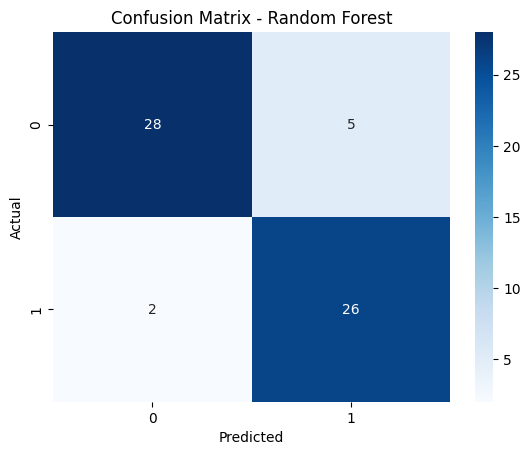

In [532]:
with mlflow.start_run(run_name="Random Forest"):
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 200)

    rf_pipeline.fit(X_train, y_train)

    metrics, y_prob = evaluate_model(
        rf_pipeline, X_test, y_test
    )

    for key, value in metrics.items():
        mlflow.log_metric(key, value)

    RocCurveDisplay.from_estimator(
        rf_pipeline, X_test, y_test
    )
    plt.title("ROC Curve - Random Forest")
    plt.savefig("roc_rf.png")
    mlflow.log_artifact("roc_rf.png")
    plt.close()

    mlflow.sklearn.log_model(
        rf_pipeline,
        artifact_path="model"
    )

    from sklearn.metrics import classification_report
    print("Random Forest Classification Report")
    print(classification_report(y_test, y_pred))

    y_pred = rf_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Random Forest")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

In [533]:
mlflow.get_experiment_by_name("Heart Disease Classification")
print("Experiment retrieval completed.")

Experiment retrieval completed.
